In [1]:
import sys
import torch
import geoopt

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from geoopt import linalg, ManifoldParameter, Stiefel
from geoopt.optim import RiemannianSGD, RiemannianAdam
from copy import deepcopy

sys.path.append("./lib/data")
from get_data import get_data, get_cov2

sys.path.append("./lib")
from swspd import sliced_wasserstein_spd
# from transformations import Translation, Rotation, sym_reeig

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [3]:
def plot_embedding(Xs, Xt, suptitle=None, embedding="tsne"):
    d = Xs.shape[-1]
    log_Xs = linalg.sym_logm(Xs.detach().cpu()).reshape(-1, d*d)
    log_Xt = linalg.sym_logm(Xt.detach().cpu()).reshape(-1, d*d)

    log_data = torch.cat([log_Xs, log_Xt], dim=0)
    
    if embedding == "tsne":
        X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(log_data.numpy())
    elif embedding == "pca":
        X_embedded = PCA(n_components=2).fit_transform(log_data.numpy())
    elif embedding == "spectral":
        X_embedded = SpectralEmbedding(n_components=2).fit_transform(log_data.numpy())


    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
    ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

    ax[0].legend()
    ax[1].legend()
    
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.show()

### Data

In [4]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov2(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(1, False, "./dataset/")
cov_Xt = torch.tensor(get_cov2(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

# plot_embedding(cov_Xs[:,:,0], cov_Xt[:,:,0], suptitle="PCA Subject "+str(subject), embedding="pca")

print(cov_Xs.shape, cov_Xt.shape)

torch.Size([273, 1, 43, 22, 22]) torch.Size([281, 1, 43, 22, 22])


### NN

In [5]:
class Translation(nn.Module):
    def __init__(self, d, n_freq, device):
        super().__init__()

        manifold_spdai = geoopt.SymmetricPositiveDefinite("AIM")        
        self._W = ManifoldParameter(torch.eye(d, dtype=torch.double, device=device)[None, :].repeat(n_freq, 1, 1), manifold=manifold_spdai)

        with torch.no_grad():
            self._W.proj_()

    def forward(self, X):
        return torch.matmul(self._W, torch.matmul(X, self._W.transpose(2, 1)))

class Rotation(nn.Module):
    def __init__(self, d, n_freq, device):
        super().__init__()

        manifold = Stiefel()        
        self._W = ManifoldParameter(torch.eye(d, dtype=torch.double, device=device)[None, :].repeat(n_freq, 1, 1), manifold=manifold)

        with torch.no_grad():
            self._W.proj_()

    def forward(self, X):
        return torch.matmul(self._W, torch.matmul(X, self._W.transpose(2, 1)))


class Transformations(nn.Module):
    def __init__(self, d, n_freq, device, seed=42):
        super().__init__()
        torch.manual_seed(seed)
        self.translation = Translation(d, n_freq, device)
        self.rotation = Rotation(d, n_freq,device)

    def forward(self, X):
        Y = self.translation(X)
        Y = self.rotation(Y)
        return Y

In [6]:
# class SPDNet(nn.Module):
#     def __init__(self, d):
#         super().__init__()
        
#         self.translation1 = Translation(d)
#         self.rotation1 = Rotation(d)
        
#         self.translation2 = Translation(d)
#         self.rotation2 = Rotation(d)
    
#     def forward(self, X):
# #         Y = self.rotation1(self.translation1(X))
# #         Y = self.rotation1(X)
#         Y = sym_reeig(self.rotation1(self.translation1(X)))
#         Y = self.rotation2(self.translation2(Y))
        
#         return Y

In [7]:
# class BasicTransf(nn.Module):
#     def __init__(self, d):
#         super().__init__()
        
#         self.translation1 = Translation(d)
#         self.rotation1 = Rotation(d)
    
#     def forward(self, X):
#         Y = self.rotation1(self.translation1(X))
        
#         return Y

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin


class FeaturesKernel(BaseEstimator, TransformerMixin):
    
    def __init__(self, sigma=1.):
        self.sigma = sigma
    
    def fit(self, X, y=None):
        self.X = X.astype(np.float64)
        self.N =  np.sum(self.X ** 2, axis=(2, 3))
#         print(self.N)
        return self
    
    def transform(self, X, y=None):
        C = 1.
        X_d = X.astype(np.float64)
        
#         print("??", self.N)
        
        N = np.sum(X_d ** 2, axis=(2, 3))
        for i in range(X_d.shape[1]):
            C1 = self.N[None, :, i] + N[:, i, None]
            C2 = X_d[:, i].reshape(X_d.shape[0], -1) @ self.X[:, i].reshape(self.X.shape[0], -1).T
            C_current = np.exp(-(C1 - 2 * C2) / (self.sigma ** 2))
            C += C_current
        
        return C 
    
    def get_params(self, deep=True):
        return {"sigma": self.sigma}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Subject 1 to 3

In [17]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov2(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(3, True, "./dataset/")
cov_Xt = torch.tensor(get_cov2(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [18]:
d = 22
n_classes = 4
n_freq = cov_Xs.shape[2]

In [19]:
epochs = 500
num_projs = 500

model = Transformations(d, n_freq, device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

L_loss = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs)
    loss = 0
    for i in range(zs.shape[2]):
        sw = sliced_wasserstein_spd(zs[:,0,i], cov_Xt[:,0,i], num_projs, device, p=2)
        loss += sw
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:16:04<00:00, 16.33s/it, loss = 0.207]


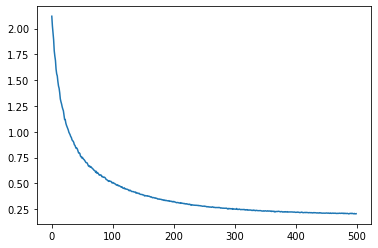

In [20]:
plt.plot(L_loss)
plt.show()

In [24]:
log_Xs = linalg.sym_logm(model(cov_Xs)[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.6555555555555556


In [25]:
log_Xs = linalg.sym_logm(cov_Xs[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.5037037037037037


In [26]:
import ot

2023-01-02 13:47:47.145200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 13:47:47.401711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-02 13:47:47.401746: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-02 13:47:48.762511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [31]:
epochs = 500
num_projs = 500

model = Transformations(d, n_freq, device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-2)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

manifold_spdai = geoopt.SymmetricPositiveDefinite("LEM")        


L_loss = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs)
    loss = 0
    for i in range(zs.shape[2]):
#         sw = sliced_wasserstein_spd(zs[:,0,i], cov_Xt[:,0,i], num_projs, device, p=2)
#         loss += sw
        
        a = torch.ones((len(zs),), device=device, dtype=torch.float64)/len(zs)
        b = torch.ones((len(cov_Xt),), device=device, dtype=torch.float64)/len(cov_Xt)
        M = manifold_spdai.dist(zs[:,0,i][:,None], cov_Xt[:,0,i][None])**2
        loss += 0.1 * ot.emd2(a, b, M)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:14:43<00:00,  8.97s/it, loss = 272.548]


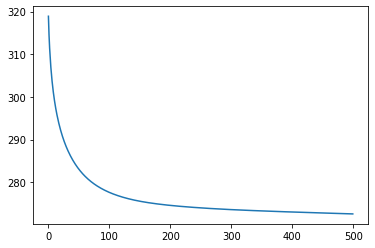

In [32]:
plt.plot(L_loss)
plt.show()

In [33]:
log_Xs = linalg.sym_logm(model(cov_Xs)[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.6296296296296297


In [34]:
log_Xs = linalg.sym_logm(cov_Xs[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.5037037037037037


In [36]:
epochs = 500
num_projs = 500

model = Transformations(d, n_freq, device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-3)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

manifold_spdai = geoopt.SymmetricPositiveDefinite("LEM")        


L_loss = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs)
    loss = 0
    for i in range(zs.shape[2]):
#         sw = sliced_wasserstein_spd(zs[:,0,i], cov_Xt[:,0,i], num_projs, device, p=2)
#         loss += sw
        
        a = torch.ones((len(zs),), device=device, dtype=torch.float64)/len(zs)
        b = torch.ones((len(cov_Xt),), device=device, dtype=torch.float64)/len(cov_Xt)
        M = manifold_spdai.dist(zs[:,0,i][:,None], cov_Xt[:,0,i][None])**2
        loss += 0.1 * ot.emd2(a, b, M)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:02:52<00:00,  7.55s/it, loss = 283.083]


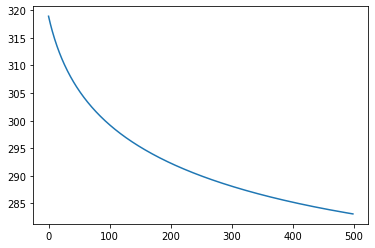

In [37]:
plt.plot(L_loss)
plt.show()

In [38]:
log_Xs = linalg.sym_logm(model(cov_Xs)[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.6222222222222222


In [39]:
epochs = 500
num_projs = 500

model = Transformations(d, n_freq, device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

manifold_spdai = geoopt.SymmetricPositiveDefinite("LEM")        


L_loss = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs)
    loss = 0
    for i in range(zs.shape[2]):
#         sw = sliced_wasserstein_spd(zs[:,0,i], cov_Xt[:,0,i], num_projs, device, p=2)
#         loss += sw
        
        a = torch.ones((len(zs),), device=device, dtype=torch.float64)/len(zs)
        b = torch.ones((len(cov_Xt),), device=device, dtype=torch.float64)/len(cov_Xt)
        M = manifold_spdai.dist(zs[:,0,i][:,None], cov_Xt[:,0,i][None])**2
        loss += 0.1 * ot.emd2(a, b, M)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [54:53<00:00,  6.59s/it, loss = 906.837]


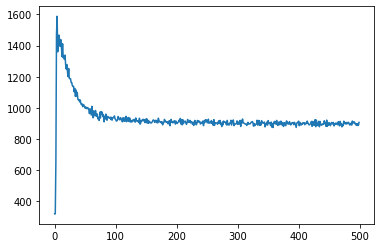

In [40]:
plt.plot(L_loss)
plt.show()

In [41]:
log_Xs = linalg.sym_logm(model(cov_Xs)[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.4444444444444444


### Cross Session - Subject 1

In [9]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov2(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(1, False, "./dataset/")
cov_Xt = torch.tensor(get_cov2(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [10]:
d = 22
n_classes = 4
n_freq = cov_Xs.shape[2]

In [11]:
epochs = 500
num_projs = 500

model = Transformations(d, n_freq, device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

L_loss = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs)
    loss = 0
    for i in range(zs.shape[2]):
        sw = sliced_wasserstein_spd(zs[:,0,i], cov_Xt[:,0,i], num_projs, device, p=2)
        loss += sw
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:32:24<00:00, 11.09s/it, loss = 0.112]


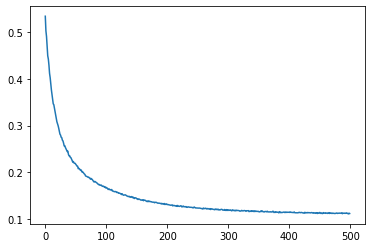

In [12]:
plt.plot(L_loss)
plt.show()

In [15]:
log_Xs = linalg.sym_logm(model(cov_Xs)[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.8540925266903915


In [16]:
log_Xs = linalg.sym_logm(cov_Xs[:, 0]).detach().cpu().numpy()
log_Xt = linalg.sym_logm(cov_Xt[:, 0]).detach().cpu().numpy()


svc = make_pipeline(
    FeaturesKernel(7),
    GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10), "kernel": ["precomputed"]}, n_jobs=10)
)

# svc = LinearSVC(C = 0.1, intercept_scaling=1., max_iter=10000, loss='hinge', multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)

svc.fit(log_Xs, ys.cpu())
print(svc.score(log_Xs, ys.cpu()))
print(svc.score(log_Xt, yt.cpu()))

1.0
0.8327402135231317
